In [58]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import numpy as np 
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
df = pd.read_csv('data.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [60]:
# Определим размеры датасета
print(df.shape)
# видим, большое количество признаков

# столбец id следует сделать индексом данных
df = df.set_index('Id', drop = True)
df.head()

(1460, 81)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

# Обработка пропущенных значений


              Missing Ratio
PoolQC            99.520548
MiscFeature       96.301370
Alley             93.767123
Fence             80.753425
MasVnrType        59.726027
FireplaceQu       47.260274
LotFrontage       17.739726
GarageType         5.547945
GarageYrBlt        5.547945
GarageFinish       5.547945
GarageQual         5.547945
GarageCond         5.547945
BsmtFinType2       2.602740
BsmtExposure       2.602740
BsmtFinType1       2.534247
BsmtCond           2.534247
BsmtQual           2.534247
MasVnrArea         0.547945
Electrical         0.068493


Text(0.5, 1.0, 'Percent missing data by feature')

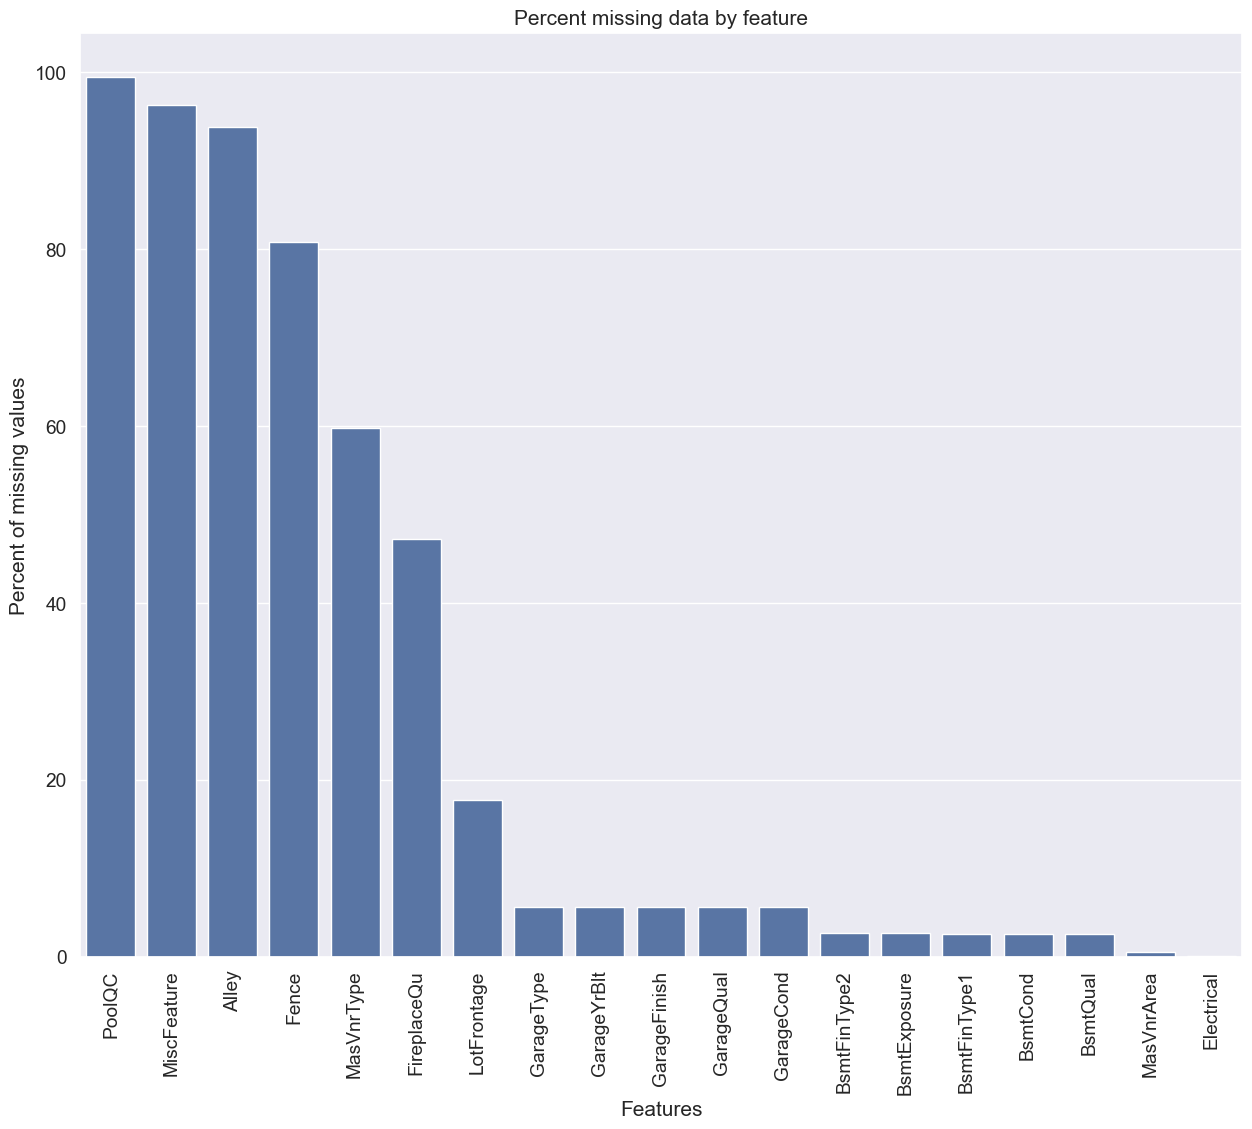

In [61]:
# Проверка пропущенных значений
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data)

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## Заполнение пропущенных значений

Видим, что у некоторых признаков большая часть значений пропущена, это плохо и нужно исправить.

- **PoolQC**: NA означает отсутствие бассейна.  
- **MiscFeature**: NA означает отсутствие дополнительных характеристик.  
- **Alley**: NA означает отсутствие доступа к переулку.  
- **Fence**: NA означает отсутствие забора.  
- **FireplaceQu**: NA означает отсутствие камина.  
- **LotFrontage**: Пропущенные значения заполняются медианой по соседству, так как размер участка, вероятно, схож с соседними домами.  
- **GarageType, GarageFinish, GarageQual, GarageCond**: NA заменяется на `'None'`.  
- **GarageYrBlt, GarageArea, GarageCars**: NA заменяется на `0`.  
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath**: NA заменяется на `0`.  
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2**: NA означает отсутствие подвала и заменяется на `'None'`.  
- **MasVnrArea и MasVnrType**: NA означает отсутствие облицовки; заменяется на `0` для площади и `'None'` для типа.  
- **MSZoning**: Заполняется значением `'RL'`, так как оно самое частое.  
- **Utilities**: Удаляется, так как большинство значений одинаковые, и признак не несет полезной информации.  
- **Functional**: NA означает "типичный" и заменяется на `'Typ'`.  
- **Electrical**: Один пропуск заменяется на самое частое значение `'SBrkr'`.  
- **KitchenQual**: Один пропуск заменяется на самое частое значение `'TA'`.  
- **Exterior1st и Exterior2nd**: Один пропуск в каждом столбце заменяется на самое частое значение.  
- **SaleType**: Пропущенные значения заменяются на самое частое значение `'WD'`.  
- **MSSubClass**: NA означает отсутствие класса здания и заменяется на `'None'`.



In [62]:
# Заполняем пропуски в колонках значением "None" для признаков с категориальными данными
df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

# Заполняем пропуски в "LotFrontage" медианным значением по каждой группе "Neighborhood"
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Заполняем пропуски в гараже значением "None"
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')

# Заполняем пропуски в характеристиках гаража нулем
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

# Заполняем пропуски в подвале нулем для числовых признаков
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

# Заполняем пропуски в подвале значением "None" для категориальных признаков
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

# Заполняем пропуски в "MasVnrType" значением "None" и в "MasVnrArea" нулем
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

# Заполняем пропуски в "MSZoning" наиболее частым значением
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

# Удаляем колонку "Utilities"
df = df.drop(['Utilities'], axis=1)

# Заполняем пропуски в "Functional" значением "Typ"
df["Functional"] = df["Functional"].fillna("Typ")

# Заполняем пропуски в категориальных признаках наиболее частым значением
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

# Заполняем пропуски в "MSSubClass" значением "None"
df['MSSubClass'] = df['MSSubClass'].fillna("None")

In [63]:
# удаляем строки где пропущен таргет
Target = 'SalePrice'
df.dropna(axis=0, subset=[Target], inplace=True)

all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

## Видим, что пропусков не осталось

In [64]:
# Разделяем данные на обучающую и тестовую выборки
# test_size=0.2 означает, что 20% данных будет отведено для тестирования
# random_state=42 устанавливает фиксированный начальный случай для воспроизводимости результатов
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Выводим первые несколько строк обучающей выборки для предварительного просмотра
train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
255           20       RL         70.0     8400   Pave  None      Reg   
1067          60       RL         59.0     7837   Pave  None      IR1   
639           30       RL         67.0     8777   Pave  None      Reg   
800           50       RL         60.0     7200   Pave  None      Reg   
381           50       RL         50.0     5000   Pave  Pave      Reg   

     LandContour LotConfig LandSlope  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
255          Lvl    Inside       Gtl  ...        0   None   None        None   
1067         Lvl    Inside       Gtl  ...        0   None   None        None   
639          Lvl    Inside       Gtl  ...        0   None  MnPrv        None   
800          Lvl    Corner       Gtl  ...        0   None  MnPrv        None   
381          Lvl    Inside       Gtl  ...        0   None   None        None   

     MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
Id                                                               
255        0       6    2010        WD         Normal    145000  
1067       0       5    2009        WD         Normal    178000  
639        0       5    2008        WD         Normal     85000  
800        0       6    2007        WD         Normal    175000  
381        0       5    2010        WD         Normal    127000  

[5 rows x 79 columns]

In [65]:
# Обзор целевой переменной
train_df['SalePrice'].describe()

count      1168.000000
mean     181441.541952
std       77263.583862
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      214925.000000
max      745000.000000
Name: SalePrice, dtype: float64

# Анализ Распределения Цен на Дома

Цены на дома отклоняются от нормального распределения:

- **Высокое стандартное отклонение**  
  Стандартное отклонение слишком велико

- **Минимум больше нуля**  
  Логично для цен на недвижимость

- **Большая разница между минимумом и 25-м процентилем**  
  Указывает на значительную асимметрию

- **Разница между 75-м процентилем и максимумом превышает разницу между 25-м процентилем и максимумом**  
  Демонстрирует длинный верхний хвост распределения

Распределение цен на дома отличается от нормального, что важно учитывать


Ассиметрия: 1.743129
Эксцесс: 5.475315


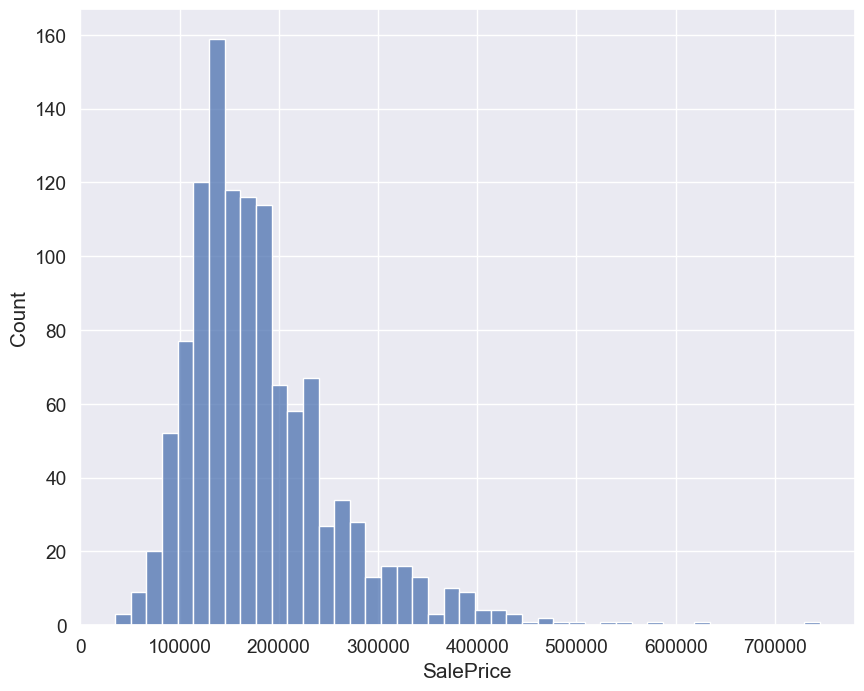

In [66]:
# визуализация
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(train_df['SalePrice'])

# Рассчитываем асимметрию и эксцесс
print("Ассиметрия: %f" % train_df['SalePrice'].skew())
print("Эксцесс: %f" % train_df['SalePrice'].kurt())
# Необходимо выполнить преобразование целевой переменной

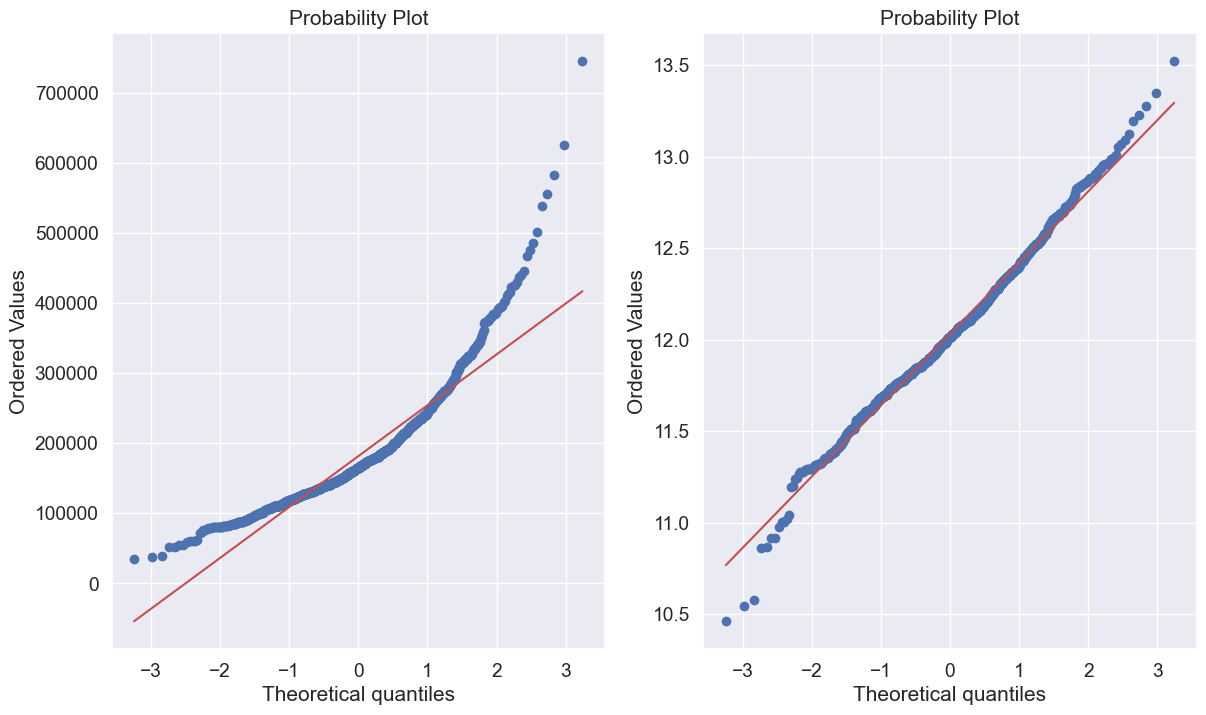

In [67]:
fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(train_df['SalePrice'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train_df['SalePrice']), plot=plt)

# Видно, что логарифмирование исправило ситуацию. Применим его ко всей выборке перед обучением

<Axes: xlabel='SalePrice', ylabel='Count'>

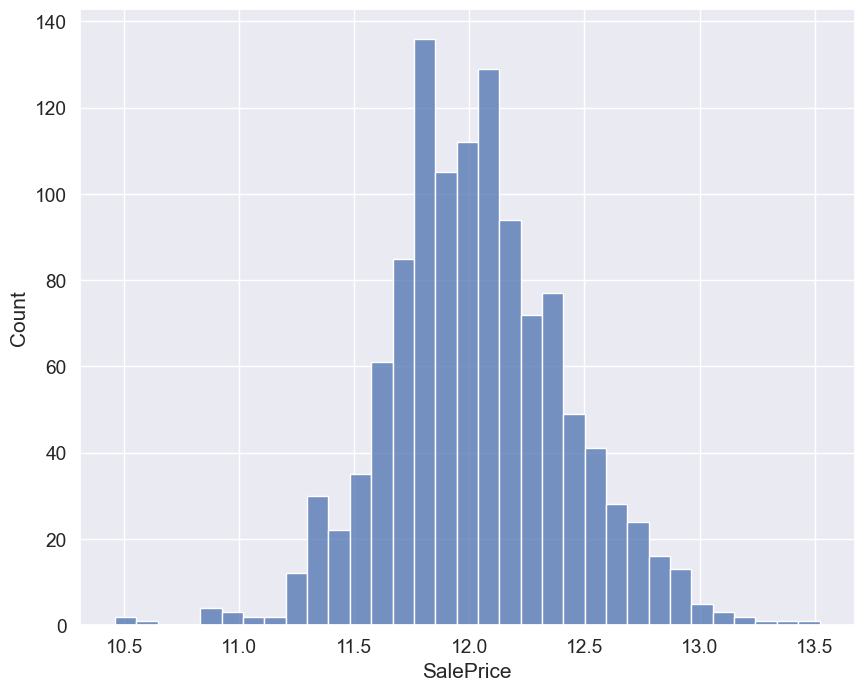

In [68]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(np.log1p(train_df['SalePrice']))

# Обзор числовых признаков

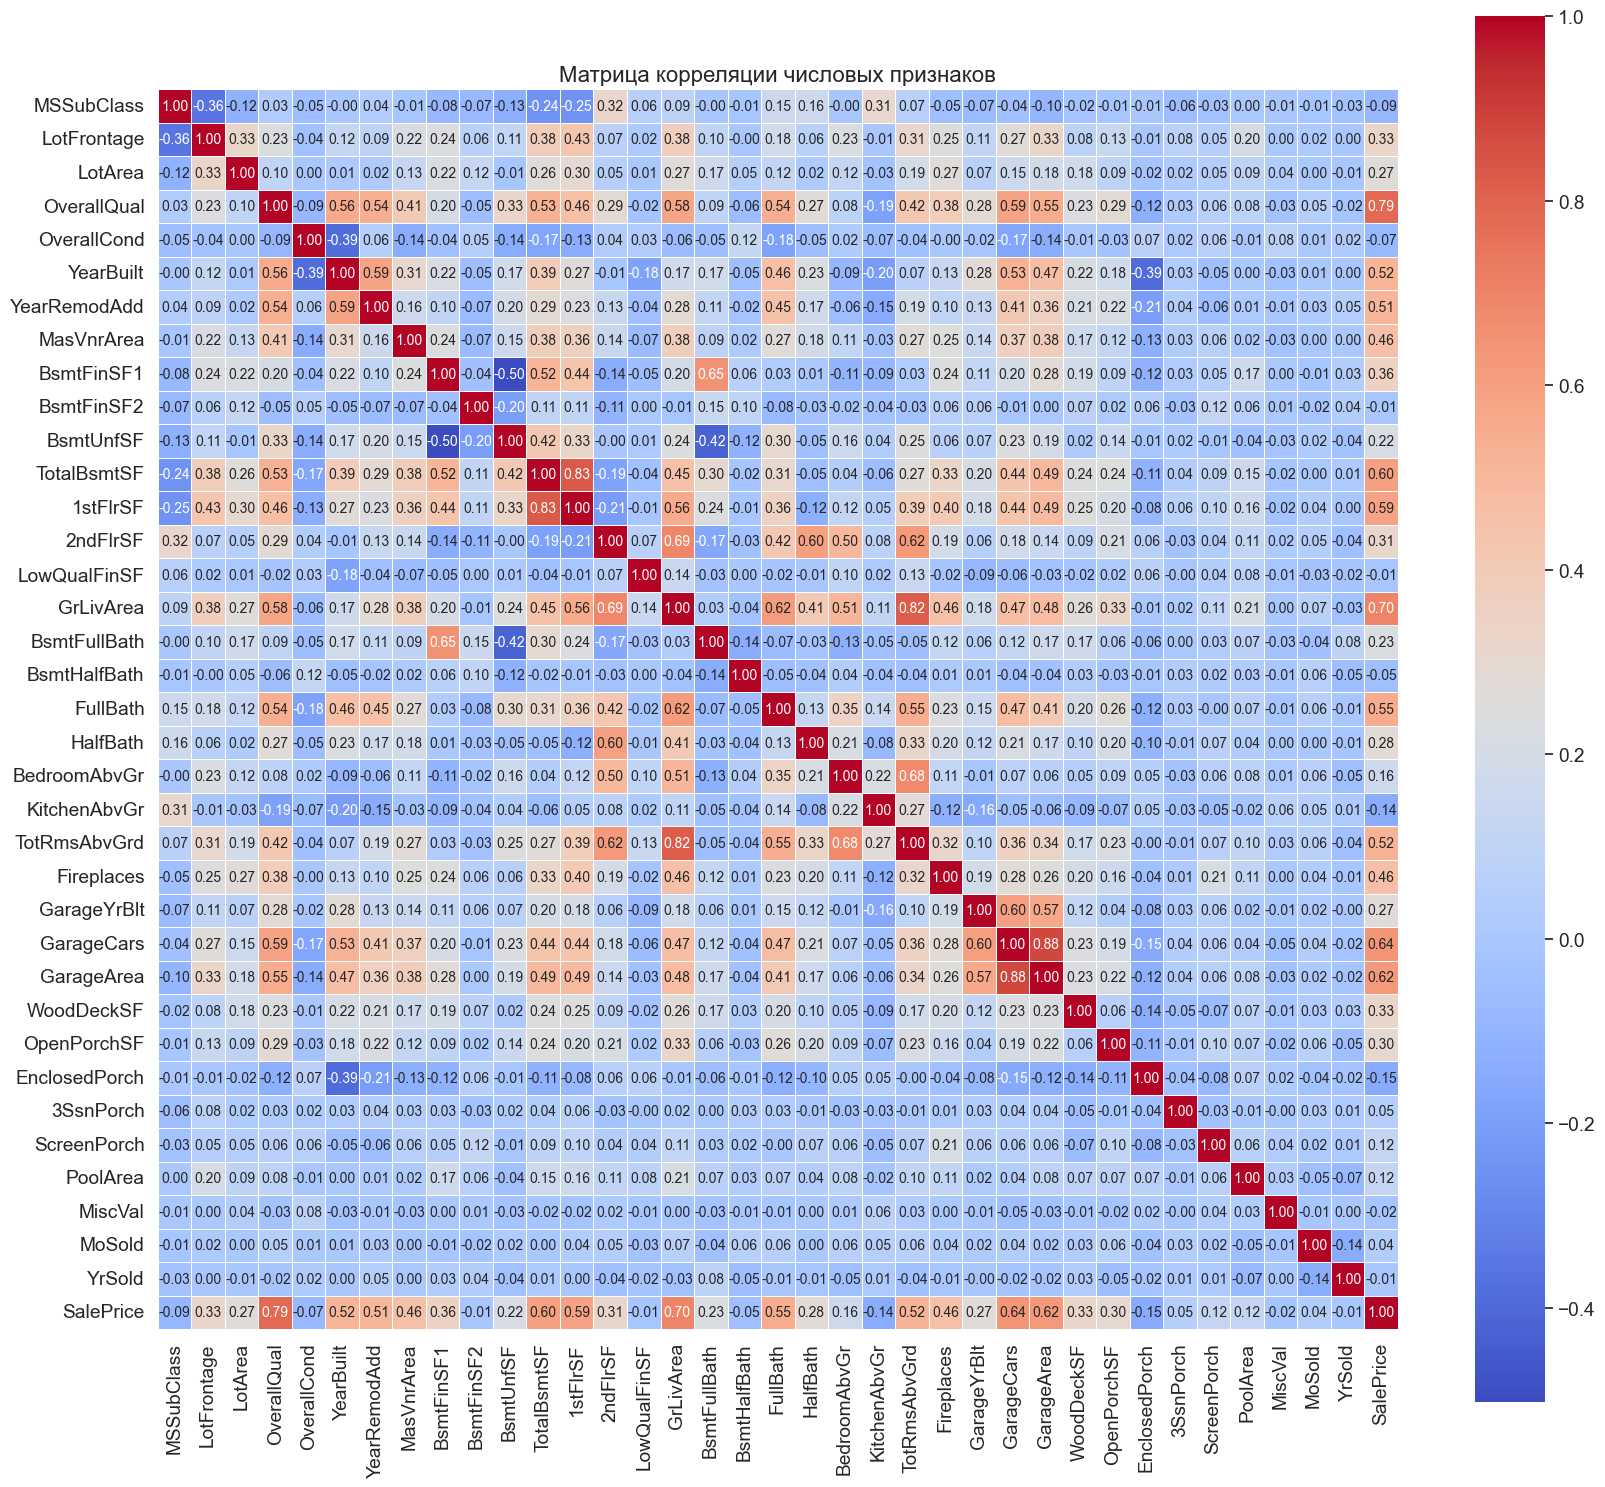

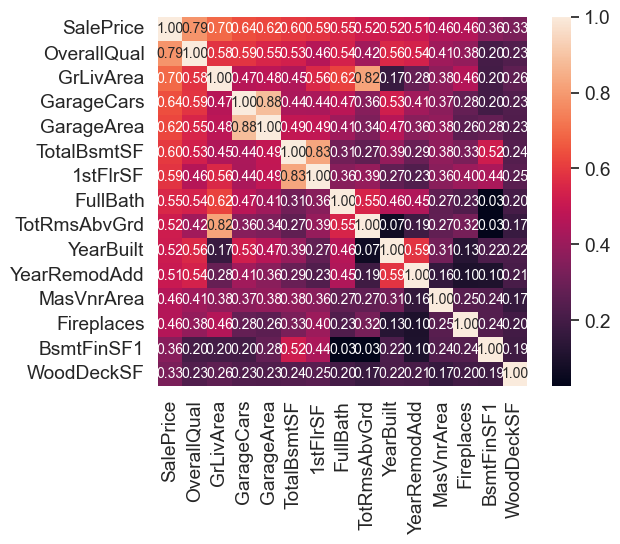

In [69]:
numeric_df = train_df.select_dtypes(include=[np.number])

# Вычисляем матрицу корреляции на числовых данных
corr_matrix = numeric_df.corr()

# Устанавливаем размер фигуры для тепловой карты
plt.figure(figsize=(20, 18))

# Построение тепловой карты корреляции с аннотациями
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',annot_kws={'size': 10}, square=True, linewidths=.5)

# Добавляем заголовок
plt.title('Матрица корреляции числовых признаков', fontsize=16)

# Отображаем график
plt.show()
k = 15 # количество коррелирующих признаков, которое мы хотим увидеть
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Напишем функцию для поиска сильно коррелированных признаков и из 2 выберем тот у которого выше корреляция с таргетом

In [70]:
def find_strong_correlations(train_df, feature_list, target='SalePrice', threshold=0.8):

    # Рассчитываем корреляцию между всеми признаками
    selected_df = train_df[feature_list]
    corr_matrix = selected_df.corr()
    plt.figure(figsize=(20, 18))

    # Построение тепловой карты корреляции с аннотациями
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',annot_kws={'size': 10}, square=True, linewidths=.5)
    
    # Добавляем заголовок
    plt.title('Матрица корреляции числовых признаков', fontsize=16)
    
    # Отображаем график
    plt.show()
    # Списки для хранения результатов
    features_with_high_corr = []
    features_to_add = []
    pairs = set()
    # Перебираем все пары признаков из двух списков
    for f1 in feature_list:
        for f2 in feature_list:
            # Чтобы не сравнивать признак с самим собой
            if f1 != f2 and target not in [f1, f2] and (f1, f2) not in pairs and (f2, f1) not in pairs:
                # Если корреляция между признаками больше порога
                if abs(corr_matrix.loc[f1, f2]) > threshold:
                    # Находим корреляцию с целевым признаком 'SalePrice'
                    corr_f1_target = abs(corr_matrix.loc[f1, target])
                    corr_f2_target = abs(corr_matrix.loc[f2, target])

                    # Добавляем в список тот признак, который сильнее коррелирует с 'SalePrice'
                    if corr_f1_target > corr_f2_target:
                        features_with_high_corr.append(f1)
                        features_to_add.append(f2)
                    else:
                        features_with_high_corr.append(f2)
                        features_to_add.append(f1)
                pairs.add((f1, f2))

    # Возвращаем два списка: признаки с высокой корреляцией с 'SalePrice' и оставшиеся признаки
    return features_with_high_corr, features_to_add

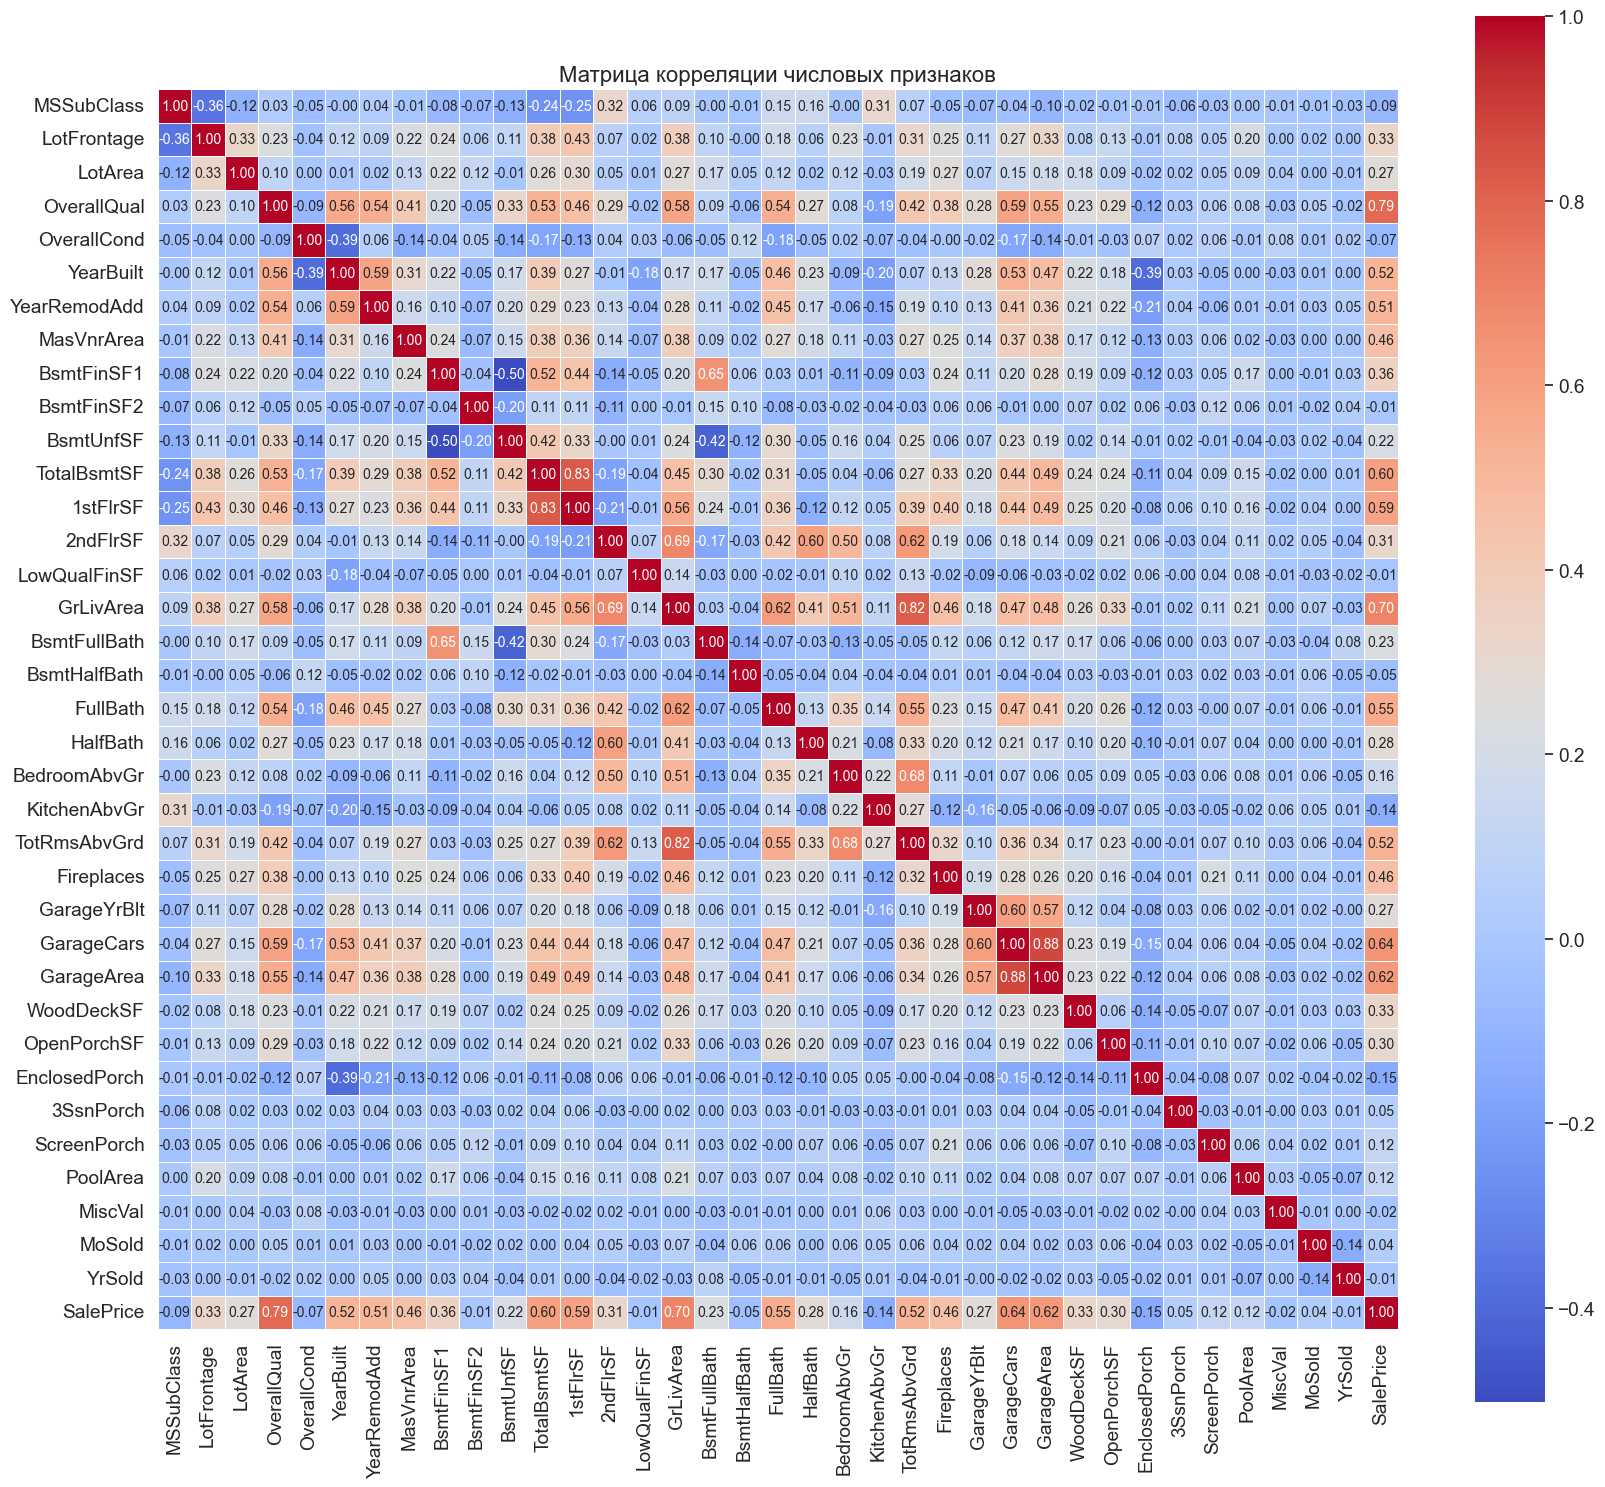

Признаки с сильной корреляцией с SalePrice: ['TotalBsmtSF', 'GrLivArea', 'GarageCars']
Оставшиеся признаки из пары (с более слабой корреляцией): ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
255           20       RL         70.0     8400   Pave  None      Reg   
1067          60       RL         59.0     7837   Pave  None      IR1   
639           30       RL         67.0     8777   Pave  None      Reg   
800           50       RL         60.0     7200   Pave  None      Reg   
381           50       RL         50.0     5000   Pave  Pave      Reg   
...          ...      ...          ...      ...    ...   ...      ...   
1096          20       RL         78.0     9317   Pave  None      IR1   
1131          50       RL         65.0     7804   Pave  None      Reg   
1295          20       RL         60.0     8172   Pave  None      Reg   
861           50       RL         55.0     7642   Pave  None      Reg   
1127         120       RL         53.0     3684   Pave  None      Reg   

     LandContour LotConfig LandSlope  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
255          Lvl    Inside       Gtl  ...        0   None   None        None   
1067         Lvl    Inside       Gtl  ...        0   None   None        None   
639          Lvl    Inside       Gtl  ...        0   None  MnPrv        None   
800          Lvl    Corner       Gtl  ...        0   None  MnPrv        None   
381          Lvl    Inside       Gtl  ...        0   None   None        None   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1096         Lvl    Inside       Gtl  ...        0   None   None        None   
1131         Lvl    Inside       Gtl  ...        0   None  MnPrv        None   
1295         Lvl    Inside       Gtl  ...        0   None   None        None   
861          Lvl    Corner       Gtl  ...        0   None  GdPrv        None   
1127         Lvl    Inside       Gtl  ...        0   None   None        None   

     MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
Id                                                               
255        0       6    2010        WD         Normal    145000  
1067       0       5    2009        WD         Normal    178000  
639        0       5    2008        WD         Normal     85000  
800        0       6    2007        WD         Normal    175000  
381        0       5    2010        WD         Normal    127000  
...      ...     ...     ...       ...            ...       ...  
1096       0       3    2007        WD         Normal    176432  
1131       0      12    2009        WD         Normal    135000  
1295       0       4    2006        WD         Normal    115000  
861        0       6    2007        WD         Normal    189950  
1127       0       6    2009        WD         Normal    174000  

[1168 rows x 76 columns]

In [71]:
feature_num = list(train_df.select_dtypes(include=[np.number]).columns)
high_corr_features, other_features = find_strong_correlations(train_df, feature_num)

print("Признаки с сильной корреляцией с SalePrice:", high_corr_features)
print("Оставшиеся признаки из пары (с более слабой корреляцией):", other_features)
test_df.drop(columns=other_features)
train_df.drop(columns=other_features)

# Признаки, коррелирующие между собой, могут мешать обучению. Удалим часть из них

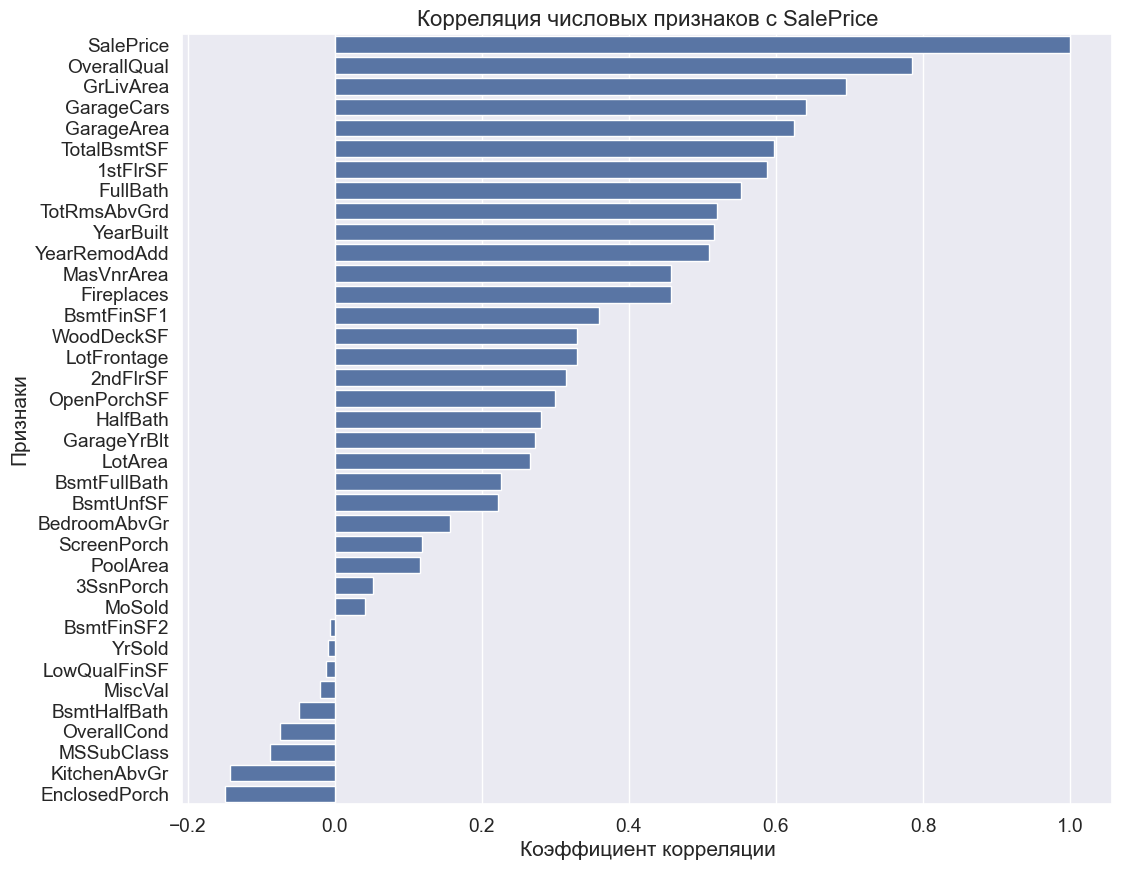

In [72]:
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
# Дополнительно: Вывод наиболее коррелированных признаков с целевой переменной
plt.figure(figsize=(12, 10))
# Сортируем по корреляции с SalePrice
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Корреляция числовых признаков с SalePrice', fontsize=16)
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Признаки')
plt.show()

# Рассмотрим значения признаков, сильно коррелирующих с таргетом, и отбросим зашумленные строки датасета (шум)

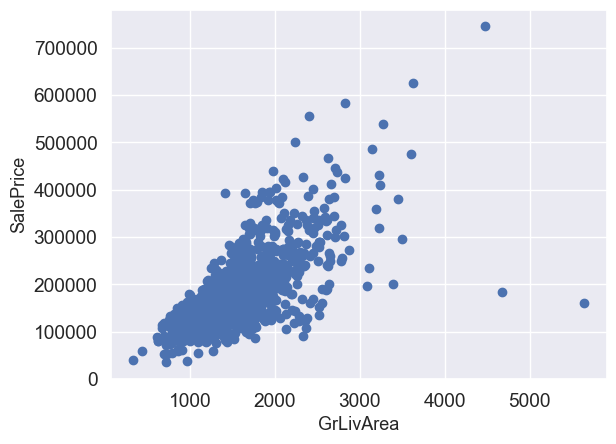

In [73]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

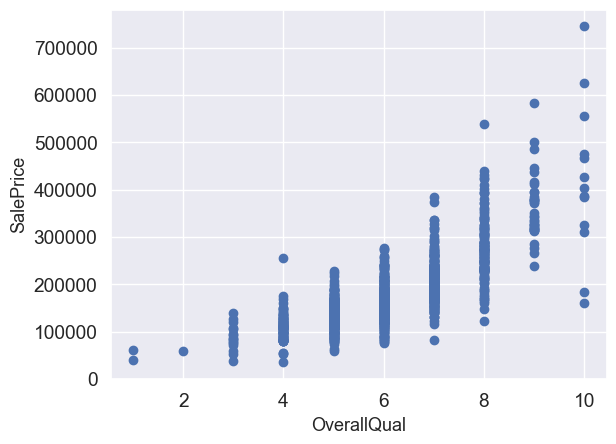

In [74]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['OverallQual'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

In [75]:
# Очищаем данные
train_df = train_df.drop(train_df[(train_df['OverallQual'] > 10) & (train_df['SalePrice'] < 220000)].index)
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

# Обзор категориальных признаков

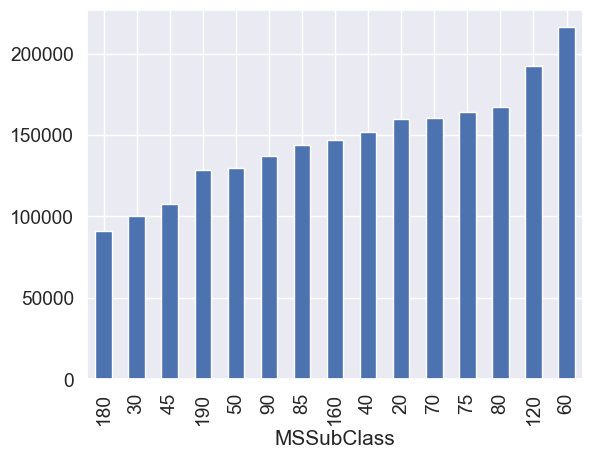

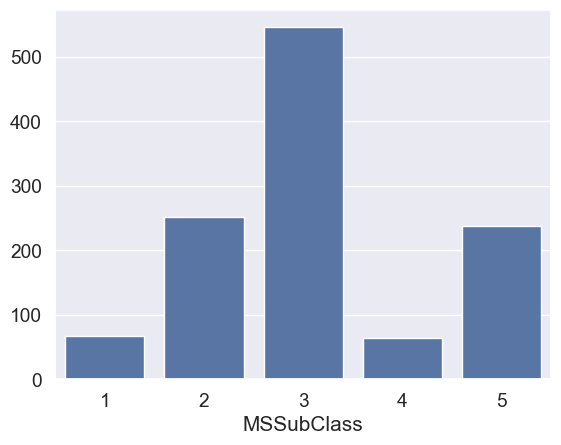

      MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                          
255            3         3         70.0     8400       1      1         1   
1067           5         3         59.0     7837       1      1         2   
639            1         3         67.0     8777       1      1         1   
800            2         3         60.0     7200       1      1         1   
381            2         3         50.0     5000       1      2         1   

      LandContour  LotConfig  LandSlope  ...  PoolArea  PoolQC  Fence  \
Id                                       ...                            
255             3          4          0  ...         0       3      4   
1067            3          4          0  ...         0       3      4   
639             3          4          0  ...         0       3      2   
800             3          0          0  ...         0       3      2   
381             3     

In [76]:
# Список категориальных признаков (не числовые)
feature_cat = list(train_df.select_dtypes(exclude=[np.number]).columns)
# Выберем порядковые признаки судя по описанию это числовой 'MSSubClass' и категориальные 'ExterQual', 'HeatingQC', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'LotShape'
# Маппинг порядковых признаков с числовыми значениями
# Для признаков качества: 'ExterQual', 'HeatingQC'
qual_dict1 = {"None": 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
train_df['ExterQual'] = train_df['ExterQual'].map(qual_dict1).astype(int)
test_df['ExterQual'] = test_df['ExterQual'].map(qual_dict1).astype(int)
train_df['HeatingQC'] = train_df['HeatingQC'].map(qual_dict1).astype(int)
test_df['HeatingQC'] = test_df['HeatingQC'].map(qual_dict1).astype(int)

# Для признаков типа отделки подвала: 'BsmtFinType1', 'BsmtFinType2'
qual_dict2 = {"None": 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].map(qual_dict2).astype(int)
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(qual_dict2).astype(int)
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].map(qual_dict2).astype(int)
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].map(qual_dict2).astype(int)

# Для признаков типа отделки гаража: 'GarageFinish'
qual_dict3 = {"None": 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
train_df['GarageFinish'] = train_df.GarageFinish.map(qual_dict3).astype(int)
test_df['GarageFinish'] = test_df.GarageFinish.map(qual_dict3).astype(int)

# Для признаков формы участка: 'LotShape'
qual_dict4 = {"None": 0, 'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}
train_df['LotShape'] = train_df.LotShape.map(qual_dict4).astype(int)
test_df['LotShape'] = test_df.LotShape.map(qual_dict4).astype(int)

# Список порядковых признаков после маппинга
feature_ordinal = ['ExterQual', 'HeatingQC', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'LotShape']

# Удаляем порядковые признаки из списка категориальных признаков
for x in feature_ordinal:
    feature_cat.remove(x)

# Строим график медианного значения 'SalePrice' по 'MSSubClass'
median_saleprice = train_df.groupby(['MSSubClass'])['SalePrice'].median().sort_values()
median_saleprice.plot(kind='bar')
plt.show()

# Замена значений в 'MSSubClass' по заданному маппингу
remap = {180: 1, 30: 1, 45: 1, 190: 2, 50: 2, 90: 2, 85: 2, 40: 2, 160: 2, 70: 3, 20: 3, 75: 3, 80: 3, 120: 4, 60: 5}
train_df['MSSubClass'] = train_df['MSSubClass'].replace(remap)
test_df['MSSubClass'] = test_df['MSSubClass'].replace(remap)

# Строим график распределения значений 'MSSubClass'
sns.barplot(x=train_df['MSSubClass'].value_counts().index, y=train_df['MSSubClass'].value_counts().values)
plt.show()

# Кодируем категориальные признаки с помощью LabelEncoder
le = LabelEncoder()
for x in feature_cat:
    train_df[x] = le.fit_transform(train_df[x])
    test_df[x] = le.fit_transform(test_df[x])

# Выводим первые несколько строк обновленного DataFrame
print(train_df.head())


## Описание преобразования категориальных признаков в числовые значения

В данном коде выполняется преобразование категориальных признаков в числовые для обучения модели. Преобразования выполняются с использованием словарей для каждого признака. 

### 1. Признак `ExterQual`:
- Возможные значения:
  - 'Others' → 0
  - 'Po' → 1
  - 'Fa' → 2
  - 'TA' → 3
  - 'Gd' → 4
  - 'Ex' → 5

### 2. Признак `HeatingQC`:
- Возможные значения:
  - 'Others' → 0
  - 'Po' → 1
  - 'Fa' → 2
  - 'TA' → 3
  - 'Gd' → 4
  - 'Ex' → 5

### 3. Признак `BsmtFinType1`:
- Возможные значения:
  - 'Others' → 0
  - 'Unf' → 1
  - 'LwQ' → 2
  - 'Rec' → 3
  - 'BLQ' → 4
  - 'ALQ' → 5
  - 'GLQ' → 6

### 4. Признак `BsmtFinType2`:
- Возможные значения:
  - 'Others' → 0
  - 'Unf' → 1
  - 'LwQ' → 2
  - 'Rec' → 3
  - 'BLQ' → 4
  - 'ALQ' → 5
  - 'GLQ' → 6

### 5. Признак `GarageFinish`:
- Возможные значения:
  - 'Others' → 0
  - 'Unf' → 1
  - 'RFn' → 2
  - 'Fin' → 3

### 6. Признак `LotShape`:
- Возможные значения:
  - 'Others' → 0
  - 'Reg' → 1
  - 'IR1' → 2
  - 'IR2' → 3
  - 'IR3' → 4

### Итог:
Каждый из этих признаков в данных заменяется на соответствующие числовые значения, что позволяет их использовать для обучения моделей машинного обучения.

### Дополнительные шаги:

1. **Перегруппировка признака `MSSubClass`:**
   - Для категориального признака `MSSubClass` создается словарь замены, где каждый код заменяется на новое значение. Пример замены:
   - 180, 30, 45 → 1
     - 190, 50, 90, 85, 40, 160 → 2
     - и т. д.

2. **Автоматическое кодирование оставшихся категориальных признаков:**
    - Для всех остальных категориальных признаков используется `LabelEncoder`, который автоматически преобразует их в числовые значения.
    - Это позволяет преобразовать оставшиеся категориальные признаки в числовые значения, необходимые для обучения модели.


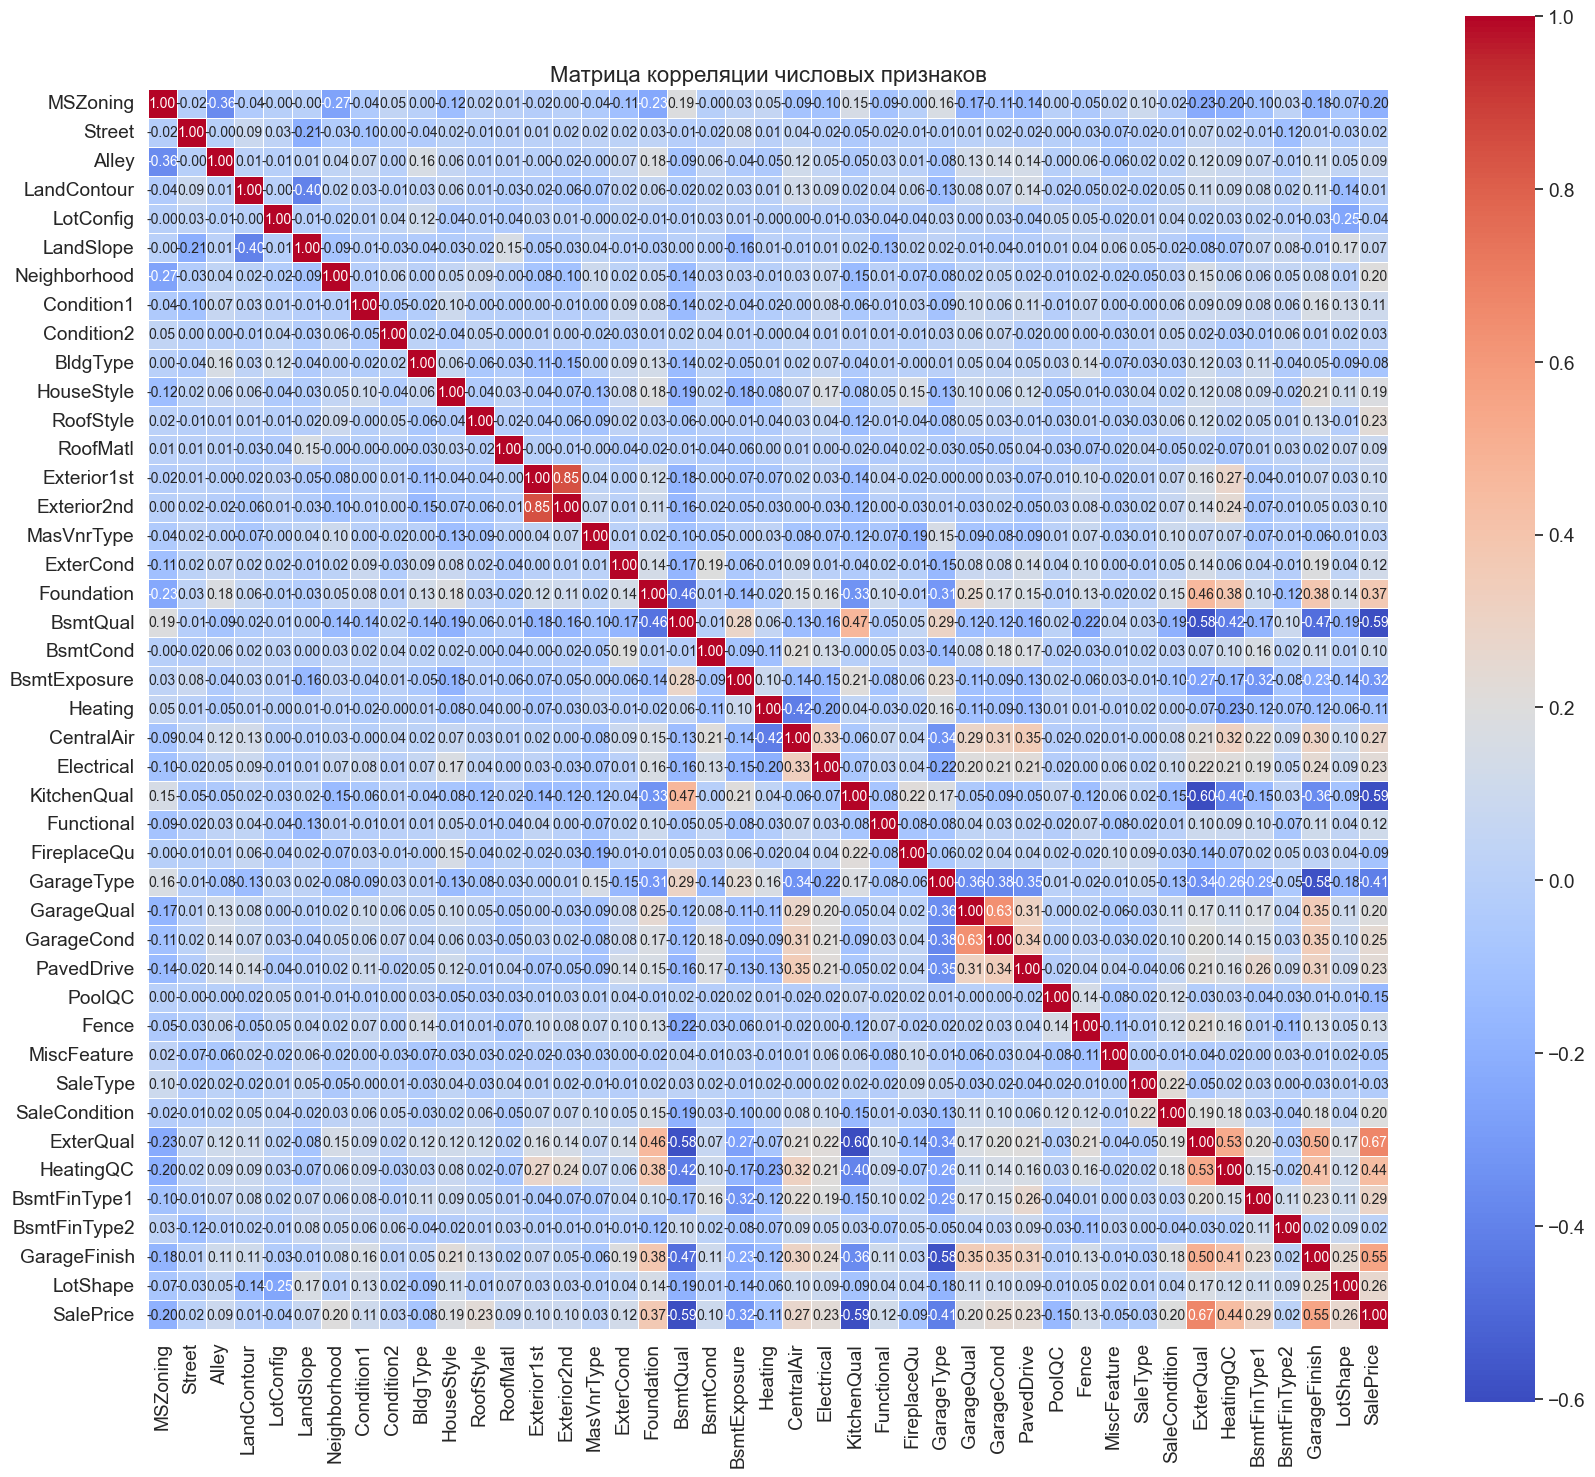

Признаки с сильной корреляцией с SalePrice: ['Exterior2nd']
Оставшиеся признаки из пары (с более слабой корреляцией): ['Exterior1st']


MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                          
255            3         3         70.0     8400       1      1         1   
1067           5         3         59.0     7837       1      1         2   
639            1         3         67.0     8777       1      1         1   
800            2         3         60.0     7200       1      1         1   
381            2         3         50.0     5000       1      2         1   
...          ...       ...          ...      ...     ...    ...       ...   
1096           3         3         78.0     9317       1      1         2   
1131           2         3         65.0     7804       1      1         1   
1295           3         3         60.0     8172       1      1         1   
861            2         3         55.0     7642       1      1         1   
1127           4         3         53.0     3684       1      1         1   

      LandContour  LotConfig  LandSlope  ...  PoolArea  PoolQC  Fence  \
Id                                       ...                            
255             3          4          0  ...         0       3      4   
1067            3          4          0  ...         0       3      4   
639             3          4          0  ...         0       3      2   
800             3          0          0  ...         0       3      2   
381             3          4          0  ...         0       3      4   
...           ...        ...        ...  ...       ...     ...    ...   
1096            3          4          0  ...         0       3      4   
1131            3          4          0  ...         0       3      2   
1295            3          4          0  ...         0       3      4   
861             3          0          0  ...         0       3      0   
1127            3          4          0  ...         0       3      4   

      MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                              
255             1        0       6    2010         8              4     145000  
1067            1        0       5    2009         8              4     178000  
639             1        0       5    2008         8              4      85000  
800             1        0       6    2007         8              4     175000  
381             1        0       5    2010         8              4     127000  
...           ...      ...     ...     ...       ...            ...        ...  
1096            1        0       3    2007         8              4     176432  
1131            1        0      12    2009         8              4     135000  
1295            1        0       4    2006         8              4     115000  
861             1        0       6    2007         8              4     189950  
1127            1        0       6    2009         8              4     174000  

[1166 rows x 78 columns]

In [77]:
high_corr_features, other_features = find_strong_correlations(train_df, feature_cat + feature_ordinal + ['SalePrice'])

print("Признаки с сильной корреляцией с SalePrice:", high_corr_features)
print("Оставшиеся признаки из пары (с более слабой корреляцией):", other_features)
test_df.drop(columns=other_features)
train_df.drop(columns=other_features)

## Подробности о Модели SVR

### Что Такое SVR?

Support Vector Regression (SVR) — это метод регрессии, основанный на алгоритме опорных векторов (SVM). В отличие от классической SVM, используемой для классификации, SVR применяется для прогнозирования непрерывных значений.

### Как Работает SVR?

- **Принцип**: SVR пытается найти функцию, отклонения предсказаний которой от реальных значений не превышают некоторого допустимого значения (ε), при этом стремясь к максимальной гладкости модели.
- **Ядра**: Используются для преобразования данных в более высокоразмерное пространство, где линейные отношения могут лучше описывать зависимости.
  - **RBF (Радиально-Базисная Функция)**: Часто используется для работы с нелинейными данными.

### Параметры Модели

- **C (Параметр Регуляризации)**:
  - Контролирует баланс между сложностью модели и допущением ошибок на обучающей выборке.
  - Высокое значение C стремится минимизировать ошибку обучения, что может привести к переобучению.

- **ε (Эпсилон-Трубка)**:
  - Определяет диапазон, в котором ошибки предсказаний не штрафуются.
  - Помогает сделать модель более устойчивой к шуму в данных.

- **Gamma**:
  - Влияет на форму функции ядра и, следовательно, на разделяющую поверхность.
  - Высокое значение gamma может привести к переобучению, низкое — к недообучению.

### Преимущества SVR

- **Устойчивость к Выбросам**: Благодаря использованию ε-трубки, модель менее чувствительна к аномальным значениям.
- **Гибкость**: Возможность использовать различные ядра для моделирования сложных зависимостей в данных.

### Недостатки SVR

- **Выбор Параметров**: Требует тщательной настройки гиперпараметров (C, ε, gamma) для достижения оптимальной производительности.
- **Вычислительная Сложность**: Обучение модели может быть ресурсоёмким при больших объёмах данных.


In [78]:
# Применяем логарифмирование ко всей выборке
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']
X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

# Модель SVR
svr_model = SVR(kernel='rbf', C=150, gamma='scale')

svr_model.fit(X_train, y_train)

# Предсказание (масштабированное) с использованием лучшей модели
y_pred_scaled = svr_model.predict(X_test)

# Восстановление масштаба целевой переменной (если использовалась логарифмическая трансформация)
y_pred_original = np.expm1(y_pred_scaled)

# Оценка модели
mse = mean_squared_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("R^2 Score:", r2)

y_test_normalized = (y_test - y_test.mean()) / y_test.std()
y_pred_normalized = (y_pred_original - y_test.mean()) / y_test.std()

mse_normalized = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Normalized MSE:", mse_normalized)

def regression_accuracy(y_true, y_pred, tolerance=0.15):
    """
    Вычисляет процент предсказаний, которые попадают в диапазон ±tolerance от истинного значения.
    Tolerance - это допустимая погрешность, например, 0.05 (5%).
    """
    # Вычисляем погрешность
    absolute_error = np.abs(y_true - y_pred)
    # Определяем допустимую погрешность
    acceptable_error = tolerance * y_true
    # Считаем, сколько предсказаний в пределах погрешности
    accuracy = np.mean(absolute_error <= acceptable_error)
    return accuracy

# Применим эту метрику к нашим данным
accuracy = regression_accuracy(y_test, y_pred_original)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Находим минимальное и максимальное отклонение
absolute_errors = np.abs(y_test - y_pred_original)
min_error = np.min(absolute_errors)
max_error = np.max(absolute_errors)

# Выводим минимальное и максимальное отклонение
print(f"\nМинимальное отклонение: {min_error:.2f}")
print(f"Максимальное отклонение: {max_error:.2f}")


MSE: 876007940.1346421
RMSE: 29597.43130973771
R^2 Score: 0.8857926095354564
Normalized MSE: 0.1138162692643226
Accuracy: 78.08%

Минимальное отклонение: 46.98
Максимальное отклонение: 131232.86


## Оценка работы модели

### 1. **Среднеквадратичная ошибка (MSE)**
   - **Значение**: 876.007.940
   - Среднеквадратичная ошибка (MSE) является важной метрикой для оценки точности модели. Чем меньше это значение, тем лучше модель предсказывает целевую переменную. В данном случае, MSE показывает, что в среднем модель ошибается на величину порядка 0.8 миллиарда. В данном контексте датасета не объективная оценка, тк цены домов имеют довольно высокие значения. Будем смотреть на нормализованную mse.

### 2. **Коэффициент детерминации (R²)**
   - **Значение**: 0.89
   - **R² = 0.89** означает, что модель объясняет 89% вариации целевой переменной. Это хороший показатель, который указывает на то, что модель достаточно точно предсказывает значения.

### 3. **Нормализованная среднеквадратичная ошибка (Normalized MSE)**
   - **Значение**: 0.113
   - Нормализованная ошибка позволяет лучше понять ошибки в контексте стандартизации данных. Чем меньше это значение, тем меньше отклонение модели относительно стандартного отклонения данных.

### 4. **Точность модели (custom Accuracy)**
   - **Значение**: 78.08%
   - Модель правильно предсказывает значения с точностью в 78.08%, что является хорошим результатом для регрессионной модели.

### 5. **Отклонения предсказаний**
   - **Минимальное отклонение**: 46.98
     - Это значение указывает на минимальное абсолютное отклонение между истинным значением и предсказанием модели. Такое отклонение свидетельствует о точности модели.
   - **Максимальное отклонение**: 131232.86
     - Это значение показывает наибольшее отклонение между предсказанным и истинным значением. Большие отклонения могут указывать на случаи, когда модель сильно ошибается.

## Вывод:
Модель показала хорошие результаты, объясняя около 89% вариации целевой переменной, с точностью 78.08%.